In [2]:
import plot
import importlib
import numpy as np
import random
import os
import glob
import h5py
import math
import scipy
import random
import classify
import warnings
import preprocess
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from os import path
from scipy import stats
from scipy.io import loadmat
from matplotlib import gridspec
from numpy.linalg import norm
from scipy.spatial import distance
from sklearn import decomposition
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.random.seed(42)
random.seed(42)


In [3]:

# reload when updating code
importlib.reload(preprocess)
# mouse and date

mice = ['NN11'] 
dates_per_mouse = {'NN11': ['210626']}

for mouse in mice:
    dates = dates_per_mouse[mouse]  # Get the list of dates for the current mouse
    days = len(dates)  # Correct number of days for this mouse
    
    for day_idx, date in enumerate(dates):
        print(mouse, date)
        
        # Create folders to save files
        paths = preprocess.create_folders(mouse, date)
        print('folders created')
        
        # Import data for mouse and date as dict
        session_data = preprocess.load_data(paths)
        print('data loaded')
        
        # Process and plot behavior
        behavior = preprocess.process_behavior(session_data, paths)
        print('behavior done')
        
        # Save masks so can run in Matlab to process other planes
        # preprocess.cell_masks(paths, 0)
        print('masks saved')
        
        # Grab activity
        deconvolved = preprocess.process_activity(paths, 'spks', 3, 0)
        print('activity processed')
        
        # Normalize activity
        norm_deconvolved = preprocess.normalize_deconvolved(deconvolved, behavior, paths, 0)
        print('activity normalized')
        
        # Gaussian filter activity
        norm_moving_deconvolved_filtered = preprocess.difference_gaussian_filter(norm_deconvolved, 4, behavior, paths, 0)
        print('activity filtered')
        
        # Make trial-averaged traces and baseline subtract
        mean_cs_1_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_1')
        mean_cs_2_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_2')
        print('traces done')
        
        # Get significant cells
        [cs_1_poscells, cs_1_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_1')
        [cs_2_poscells, cs_2_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_2')
        [both_poscells, both_sigcells] = preprocess.combine_sig(cs_1_poscells, cs_1_negcells, cs_2_poscells, cs_2_negcells)
        print('sig cells done')
        
        # Get index of top cell differences
        idx = preprocess.get_index(behavior, mean_cs_1_responses_df, mean_cs_2_responses_df, cs_1_poscells, cs_2_poscells, both_poscells, both_sigcells, paths, 1)
        print('idx done')
        
        # Get prior for synchronous cue activity
        prior = classify.prior(norm_moving_deconvolved_filtered, idx['cs_1'], idx['cs_2'], behavior, [])
        print('prior done')
        
        # Logistic regression
        y_pred_log = classify.log_regression(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)
        print('logistic regression done')
        
        # Process classified output
        y_pred = classify.process_classified(y_pred_log, prior, paths, 1)
        print('classified done')
    


NN11 210626
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


In [4]:
activity = norm_deconvolved.to_numpy()
activity = activity[idx['both'].index]

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

cos_sim = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
topn = 0.05

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

# Normalize the mean activities for each trial.
mean_activity_cs_1 = mean_activity_cs_1 / np.mean(mean_activity_cs_any, axis=0)
mean_activity_cs_2 = mean_activity_cs_2 / np.mean(mean_activity_cs_any, axis=0)

mean_activity_cs_1 = np.stack(mean_activity_cs_1, axis=0)
mean_activity_cs_2 = np.stack(mean_activity_cs_2, axis=0)

# Calculate the mean of the first and last three mean activities for cs_1 and cs_2.
n_centroids = 3
mean_activity_cs_1_mean = [np.mean(mean_activity_cs_1[0:n_centroids], axis=0), np.mean(mean_activity_cs_1[len(mean_activity_cs_1) - n_centroids:len(mean_activity_cs_1)], axis=0)]
mean_activity_cs_2_mean = [np.mean(mean_activity_cs_2[0:n_centroids], axis=0), np.mean(mean_activity_cs_2[len(mean_activity_cs_2) - n_centroids:len(mean_activity_cs_2)], axis=0)]

# Calculate the difference vectors between the early and late mean activities for cs_1 and cs_2.
mean_activity_cs_1_vec = mean_activity_cs_1_mean[1] - mean_activity_cs_1_mean[0]
mean_activity_cs_2_vec = mean_activity_cs_2_mean[1] - mean_activity_cs_2_mean[0]

late_trails_1 = mean_activity_cs_1_mean[1]
top_n_percent_indices_1 = np.argsort(late_trails_1)[-int(len(late_trails_1) * topn):]
mean_activity_cstopn_1 = mean_activity_cs_1[:, top_n_percent_indices_1]
mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

late_trails_2 = mean_activity_cs_2_mean[1]
top_n_percent_indices_2 = np.argsort(late_trails_2)[-int(len(late_trails_2) * topn):]
mean_activity_cstopn_2 = mean_activity_cs_2[:, top_n_percent_indices_2]
mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_cs_1 = np.zeros(len(mean_activity_cs_1))
sim_cs_2 = np.zeros(len(mean_activity_cs_2))

# Normalize the mean activities for each trial using the difference vectors.
for i in range(0, len(mean_activity_cs_1)):
    sim_cs_1[i] = cos_sim(mean_activity_cstopn_1[i], mean_activity_cstopn_1_late)
    # sim_cs_1[i] = cos_sim(mean_activity_cs_1[i], mean_activity_cs_1_mean[1])
    # sim_cs_1[i] = np.dot(mean_activity_cs_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_cs_2)):
    sim_cs_2[i] = cos_sim(mean_activity_cstopn_2[i], mean_activity_cstopn_2_late)
    # sim_cs_2[i] = cos_sim(mean_activity_cs_2[i], mean_activity_cs_2_mean[1])
    # sim_cs_2[i] = np.dot(mean_activity_cs_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)


# Initialize lists to store mean activities and trial indices for reactivation events.
mean_activity_r_1 = []
mean_activity_r_2 = []
mean_activity_r_any = []
trial_r_1 = []
trial_r_2 = []

# Copy reactivation predictions for cs_1 and cs_2.
reactivation_cs_1 = y_pred[:, 0].copy()
reactivation_cs_2 = y_pred[:, 1].copy()

# Set a threshold for reactivation probability.
p_threshold = .75

# Initialize variables for reactivation event detection.
cs_1_peak = 0
cs_2_peak = 0
i = 0
next_r = 0

# Loop through reactivation predictions to detect reactivation events.
while i < len(reactivation_cs_1) - 1:
    # Check if there is a reactivation event.
    if reactivation_cs_1[i] > 0 or reactivation_cs_2[i] > 0:
        if next_r == 0:
            r_start = i
            next_r = 1
        # Update peak reactivation values.
        if reactivation_cs_1[i] > cs_1_peak:
            cs_1_peak = reactivation_cs_1[i]
        if reactivation_cs_2[i] > cs_2_peak:
            cs_2_peak = reactivation_cs_2[i]
        #print(reactivation_cs_1[i + 1], reactivation_cs_2[i + 1])
        # Check if the reactivation event has ended.
        if reactivation_cs_1[i + 1] <= 0.001 and reactivation_cs_2[i + 1]<= 0.001:
            r_end = i + 1
            next_r = 0
            # Store mean activity and trial index for cs_1 reactivation events above the threshold.
            if cs_1_peak > p_threshold:
                for j in range(0, len(onsets_cs_1)):
                    if r_start < onsets_cs_1[j] and r_start > onsets_cs_1[j-1] and r_start < onsets_cs_1[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_1.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_1.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Store mean activity and trial index for cs_2 reactivation events above the threshold.
            if cs_2_peak > p_threshold:
                for j in range(0, len(onsets_cs_2)):
                    if r_start < onsets_cs_2[j] and r_start > onsets_cs_2[j-1] and r_start < onsets_cs_2[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_2.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_2.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Reset variables for the next reactivation event.
            i = r_end
            cs_1_peak = 0
            cs_2_peak = 0
    i += 1


# Normalize the reactivation mean activities.
mean_activity_r_1 = mean_activity_r_1 / np.mean(mean_activity_r_any, axis=0)
mean_activity_r_2 = mean_activity_r_2 / np.mean(mean_activity_r_any, axis=0)

mean_activity_r_1 = np.stack(mean_activity_r_1, axis=0)
mean_activity_r_2 = np.stack(mean_activity_r_2, axis=0)

# mean_activity_rtopn_1 = mean_activity_r_1[:, top_n_percent_indices_1]
# mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

# mean_activity_rtopn_2 = mean_activity_r_2[:, top_n_percent_indices_2]
# mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_r_1 = np.zeros(len(mean_activity_r_1))
sim_r_2 = np.zeros(len(mean_activity_r_2))

sim_r_1_random = np.zeros(len(mean_activity_r_1))

zero_indices = np.where(mean_activity_r_1 != 0)
    
# Normalize the reactivation mean activities using the difference vectors.
for i in range(0, len(mean_activity_r_1)):
    # nonzero_indices = np.where(mean_activity_r_1[i] != 0)
    top_n_percent_indices_r_1 = np.argsort(mean_activity_r_1[i])[-int(len(mean_activity_r_1[i]) * topn):]
    sim_r_1[i] = cos_sim(mean_activity_r_1[i][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)], mean_activity_cs_1_mean[1][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)])
    
    chosen_indices = np.random.randint(0, len(mean_activity_r_1[i]), 27)
    sim_r_1_random[i] = cos_sim(mean_activity_r_1[i][chosen_indices], mean_activity_cs_1_mean[1][chosen_indices])
    # sim_r_1[i] = cos_sim(mean_activity_rtopn_1[i], mean_activity_cstopn_1_late)
    # sim_r_1[i] = cos_sim(mean_activity_r_1[i], mean_activity_cs_1_mean[1])
    # sim_r_1[i] = np.dot(mean_activity_r_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_r_2)):
    # nonzero_indices = np.where(mean_activity_r_2[i] != 0)
    top_n_percent_indices_r_2 = np.argsort(mean_activity_r_2[i])[-int(len(mean_activity_r_2[i]) * topn):]
    sim_r_2[i] = cos_sim(mean_activity_r_2[i][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)], mean_activity_cs_2_mean[1][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)])
    # sim_r_2[i] = cos_sim(mean_activity_rtopn_2[i], mean_activity_cstopn_2_late)
    # sim_r_2[i] = cos_sim(mean_activity_r_2[i], mean_activity_cs_2_mean[1])
    # sim_r_2[i] = np.dot(mean_activity_r_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)



In [5]:
print(mean_activity_cs_1.shape)
print(mean_activity_cs_2.shape)

(68, 3124)
(60, 3124)


In [ ]:
early_trials = slice(0, 6)  # rougly first 10% of trials
late_trials = slice(-6, None)  # rouglt last 10% of trials

# Compute average activity for early and late trials
mean_activity_cs_1_early = mean_activity_cs_1[early_trials, :].mean(axis=0)  # Average over early trials
mean_activity_cs_1_late = mean_activity_cs_1[late_trials, :].mean(axis=0)  # Average over late trials

mean_activity_cs_2_early = mean_activity_cs_2[early_trials, :].mean(axis=0)
mean_activity_cs_2_late = mean_activity_cs_2[late_trials, :].mean(axis=0)

# Compute the change in activity
change_cs_1 = mean_activity_cs_1_late - mean_activity_cs_1_early  # Late - Early for CS_1
change_cs_2 = mean_activity_cs_2_late - mean_activity_cs_2_early  # Late - Early for CS_2

# Rank neurons by change in activity
ranked_neurons_cs_1 = np.argsort(change_cs_1)[::-1]  # Descending order for CS_1
ranked_neurons_cs_2 = np.argsort(change_cs_2)[::-1]  # Descending order for CS_2

num_neurons = mean_activity_cs_1.shape[1]
top10_per = int(num_neurons * 0.1) #top10 percent of neurons
print(top10_per)

# Select the top neurons with the largest positive change
top_neurons_cs_1 = ranked_neurons_cs_1[:312]  # Adjust number of top neurons as needed
top_neurons_cs_2 = ranked_neurons_cs_2[:312] #top 10%

# Subset the data for these neurons
cs1_top_learn_act = mean_activity_cs_1[:, top_neurons_cs_1]
cs2_top_learn_act = mean_activity_cs_2[:, top_neurons_cs_2]

bottom_neurons_cs_1 = ranked_neurons_cs_1[-top10_per:]
bottom_neurons_cs_2 = ranked_neurons_cs_2[-top10_per:]

cs1_bott_learn_act = mean_activity_cs_1[:, bottom_neurons_cs_1]
cs2_bott_learn_act = mean_activity_cs_2[:, bottom_neurons_cs_2]


print("Top neurons for CS_1:", len(top_neurons_cs_1))
print("Top neurons for CS_2:", len(top_neurons_cs_2))


312
Top neurons for CS_1: 312
Top neurons for CS_2: 312


In [20]:
# Compute cumulative activity across all trials for each neuron
cumulative_activity_cs_1 = mean_activity_cs_1.sum(axis=0)
cumulative_activity_cs_2 = mean_activity_cs_2.sum(axis=0)

# Rank neurons by cumulative activity
ranked_neurons_cumulative_cs_1 = np.argsort(cumulative_activity_cs_1)[::-1]
ranked_neurons_cumulative_cs_2 = np.argsort(cumulative_activity_cs_2)[::-1]

# Select the top 10% neurons
top_cumulative_neurons_cs_1 = ranked_neurons_cumulative_cs_1[:top10_per]
top_cumulative_neurons_cs_2 = ranked_neurons_cumulative_cs_2[:top10_per]

top_cumulative_neurons_cs_1_act = mean_activity_cs_1[:, top_cumulative_neurons_cs_1]
top_cumulative_neurons_cs_2_act = mean_activity_cs_2[:, top_cumulative_neurons_cs_2]

print(top_cumulative_neurons_cs_1)
print(top_cumulative_neurons_cs_2)

[3093  391  385  789  397  795 2043  607 1298  157   41 3117   29  528
  268  995  922 1347  192   15  610  612  810 2695  182  498   77   75
   50 1917  401  630  938  400  506  415  266  116  216 2943  461 1611
  693  616  697 1273  800 2241 1155  368 2942  357  412  327  389 1086
 2033  165 1990 2164  281  390  894 1792 1411  642 2850 2181 1708  680
 2784 1870 1015 1610  796  434  441  210   13  336  698 1594 1518  283
 2187  313 1397  215  139  323 1383 1016  614  119  631 1237 1795  671
  193  603 1883  383  774 1049 1573 1542 2314 1329  429 2070  104 1185
 2563 2922  762 1617  527  111  442 2289  489  369  965 2429  279  308
  768  729 2585 1116 2058 3096  350 2614 1903  673   66  398  921 1132
  386  250 1991  935  253 1019  777  726 1149 1148 2589  984  633 1553
  641 1851  714 2626  306  417 3009 1661  747 1464  334 3028  167  832
 1069 2128 2291 1443  953 2707 3048 2555  725  129  597 3038 2625 3115
  409 1506  814 1659  479 1580 2141  181  811 1623  449  924 3071 2293
 1045 

In [35]:
# Compare overlaps
def compute_overlap(set1, set2):
    """
    Compute overlap between two sets of indices.
    :param set1: Set of indices
    :param set2: Set of indices
    :return: Fractional overlap (intersection size / union size)
    """
    set1 = set(set1)  # Ensure input is a set
    set2 = set(set2)  # Ensure input is a set
    intersection = set1 & set2
    union = set1 | set2
    return len(intersection), len(union), len(intersection) / len(union)  # Overlap, total size, Jaccard index

# Compare and print overlaps
overlap_cs1_cs2 = compute_overlap(top_neurons_cs_1, top_neurons_cs_2)
overlap_cum_cs1_cs2 = compute_overlap(top_cumulative_neurons_cs_1, top_cumulative_neurons_cs_2)
top_cum_cs1 = compute_overlap(top_neurons_cs_1, top_cumulative_neurons_cs_1)
top_cum_cs2 = compute_overlap(top_neurons_cs_2, top_cumulative_neurons_cs_2)
top_cum_cs1_cs2 = compute_overlap(top_neurons_cs_1, top_cumulative_neurons_cs_2)
top_cum_cs2_cs1 = compute_overlap(top_neurons_cs_2, top_cumulative_neurons_cs_1)

print(f"Overlap between CS_1 and CS_2: {overlap_cs1_cs2[0]} / {overlap_cs1_cs2[1]} (Jaccard: {overlap_cs1_cs2[2]:.2f})")
print(f"Overlap between cumulative CS_1 and CS_2: {overlap_cum_cs1_cs2[0]} / {overlap_cum_cs1_cs2[1]} (Jaccard: {overlap_cum_cs1_cs2[2]:.2f})")
print(f"Overlap between cumulative CS_1: {top_cum_cs1[0]} / {top_cum_cs1[1]} (Jaccard: {top_cum_cs1[2]:.2f})")
print(f"Overlap between cumulative CS_2: {top_cum_cs2[0]} / {top_cum_cs2[1]} (Jaccard: {top_cum_cs2[2]:.2f})")
print(f"Overlap between cumulative CS_1 vs CS_2: {top_cum_cs1_cs2[0]} / {top_cum_cs1_cs2[1]} (Jaccard: {top_cum_cs1_cs2[2]:.2f})")
print(f"Overlap between cumulative CS_1 vs CS_2: {top_cum_cs2_cs1[0]} / {top_cum_cs2_cs1[1]} (Jaccard: {top_cum_cs2_cs1[2]:.2f})")

print(f"Set size CS_1: {len(set(top_neurons_cs_1))}")
print(f"Set size CS_2: {len(set(top_neurons_cs_2))}")
print(f"Union size: {len(set(top_neurons_cs_1) | set(top_neurons_cs_2))}")
print(f"Intersection size: {len(set(top_neurons_cs_1) & set(top_neurons_cs_2))}")
unique_to_cs_1 = set(top_neurons_cs_1) - set(top_neurons_cs_2)
unique_to_cs_2 = set(top_neurons_cs_2) - set(top_neurons_cs_1)
print(f"Unique to CS_1: {len(unique_to_cs_1)}")
print(f"Unique to CS_2: {len(unique_to_cs_2)}")
overlap = len(set(top_neurons_cs_1) & set(top_neurons_cs_2))
print(f"Overlap as fraction of CS_1: {overlap / len(top_neurons_cs_1):.2f}")
print(f"Overlap as fraction of CS_2: {overlap / len(top_neurons_cs_2):.2f}")


Overlap between CS_1 and CS_2: 74 / 550 (Jaccard: 0.13)
Overlap between cumulative CS_1 and CS_2: 0 / 624 (Jaccard: 0.00)
Overlap between cumulative CS_1: 68 / 556 (Jaccard: 0.12)
Overlap between cumulative CS_2: 52 / 572 (Jaccard: 0.09)
Overlap between cumulative CS_1 vs CS_2: 18 / 606 (Jaccard: 0.03)
Overlap between cumulative CS_1 vs CS_2: 22 / 602 (Jaccard: 0.04)
Set size CS_1: 312
Set size CS_2: 312
Union size: 550
Intersection size: 74
Unique to CS_1: 238
Unique to CS_2: 238
Overlap as fraction of CS_1: 0.24
Overlap as fraction of CS_2: 0.24


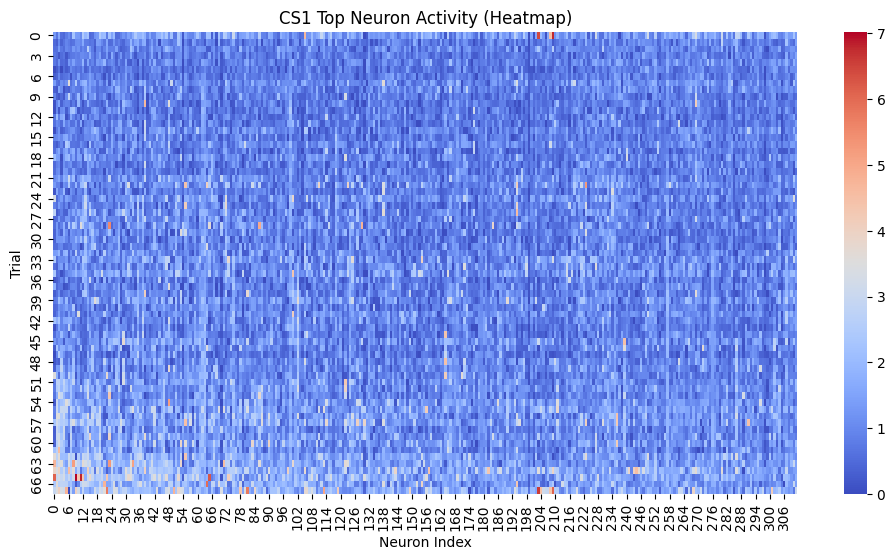

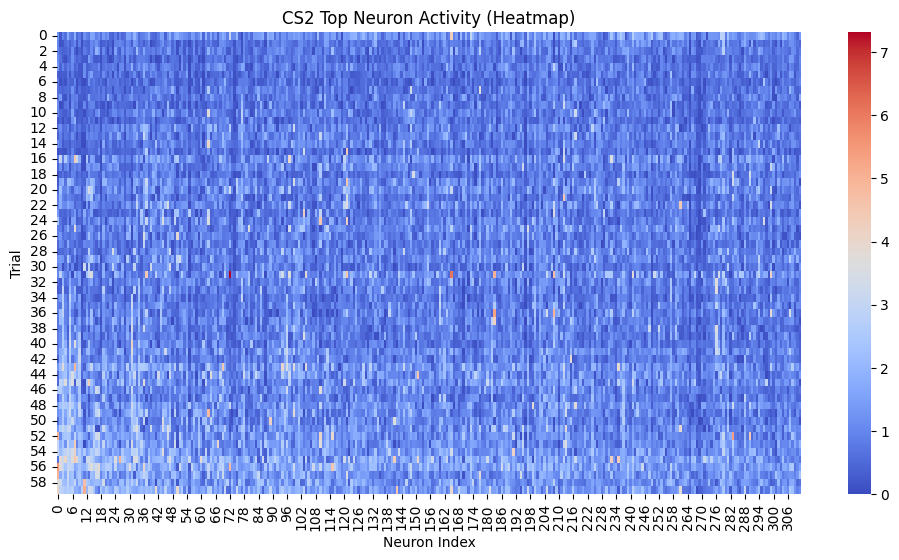

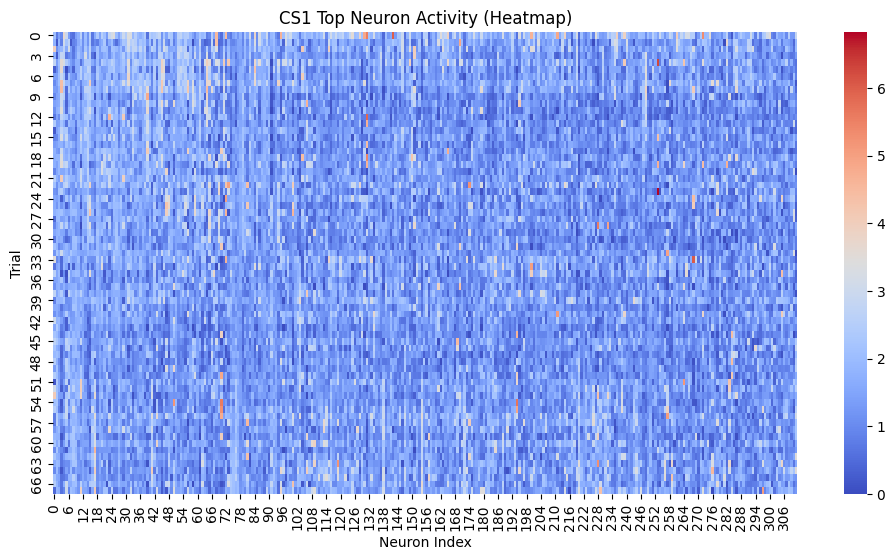

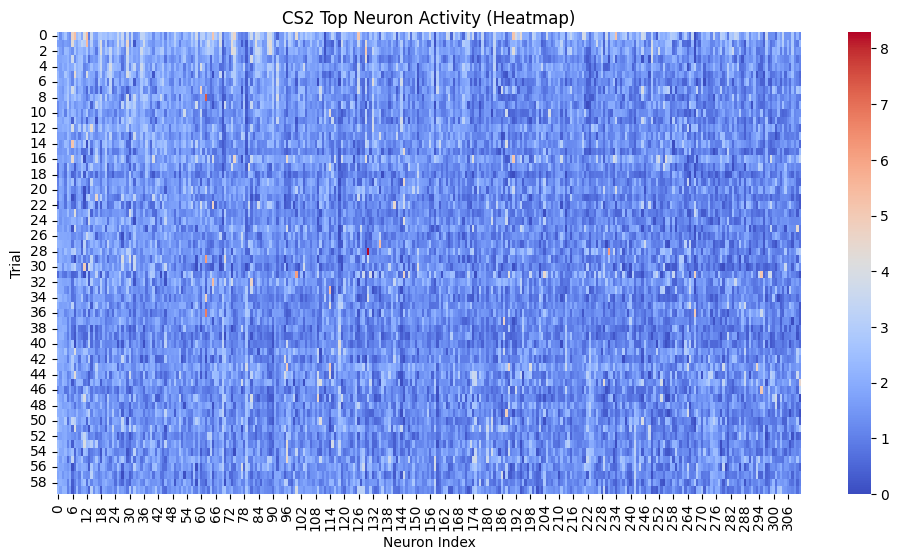

In [36]:
# Plot heatmap for CS1
plt.figure(figsize=(12, 6))
sns.heatmap(cs1_top_learn_act, cmap="coolwarm", cbar=True)
plt.title("CS1 Top Neuron Activity (Heatmap)")
plt.xlabel("Neuron Index")
plt.ylabel("Trial")
plt.show()

# Plot heatmap for CS2
plt.figure(figsize=(12, 6))
sns.heatmap(cs2_top_learn_act, cmap="coolwarm", cbar=True)
plt.title("CS2 Top Neuron Activity (Heatmap)")
plt.xlabel("Neuron Index")
plt.ylabel("Trial")
plt.show()

# Plot cumulative heatmap for CS1
plt.figure(figsize=(12, 6))
sns.heatmap(top_cumulative_neurons_cs_1_act, cmap="coolwarm", cbar=True)
plt.title("CS1 Top Neuron Activity (Heatmap)")
plt.xlabel("Neuron Index")
plt.ylabel("Trial")
plt.show()

# Plot cumulative heatmap for CS2
plt.figure(figsize=(12, 6))
sns.heatmap(top_cumulative_neurons_cs_2_act, cmap="coolwarm", cbar=True)
plt.title("CS2 Top Neuron Activity (Heatmap)")
plt.xlabel("Neuron Index")
plt.ylabel("Trial")
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


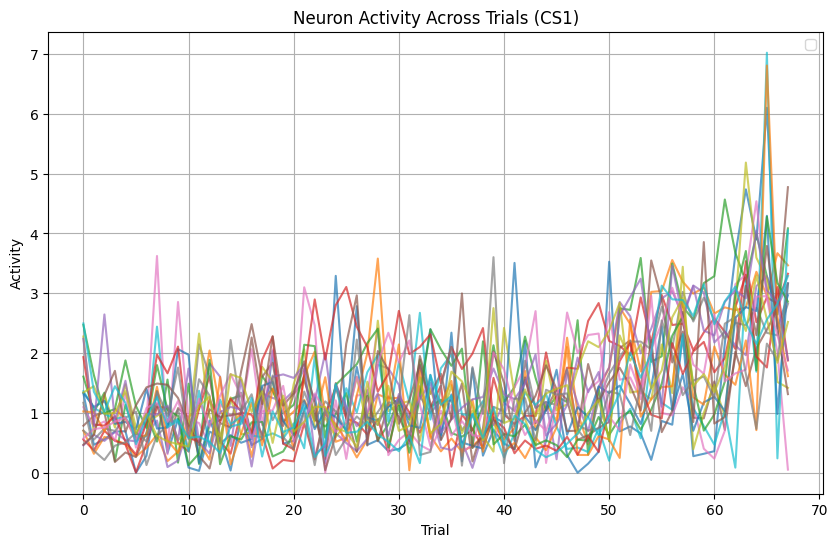

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


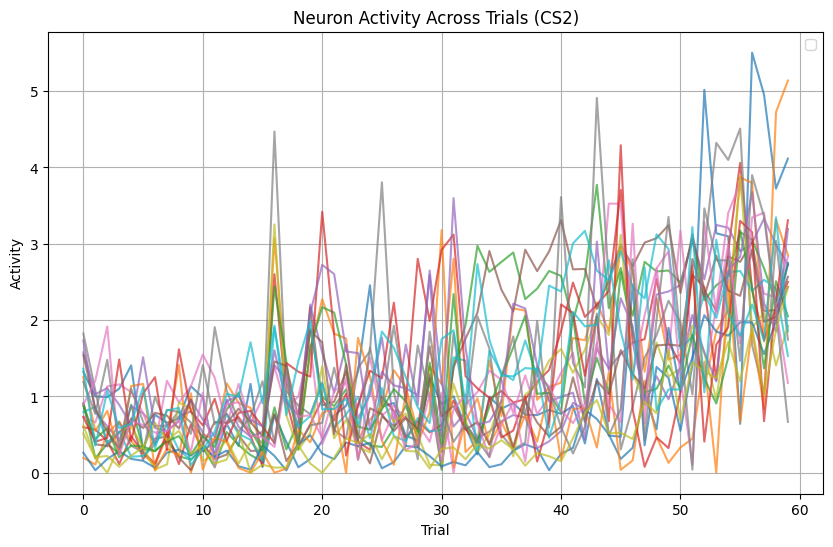

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


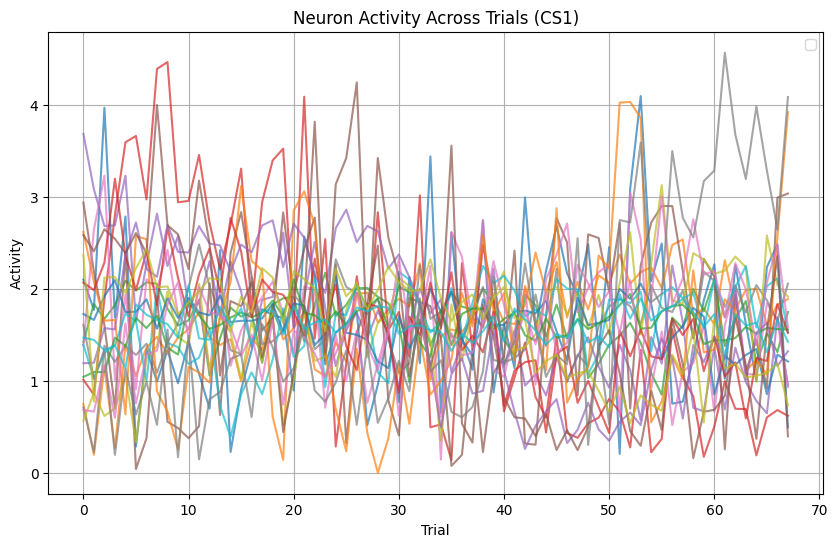

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


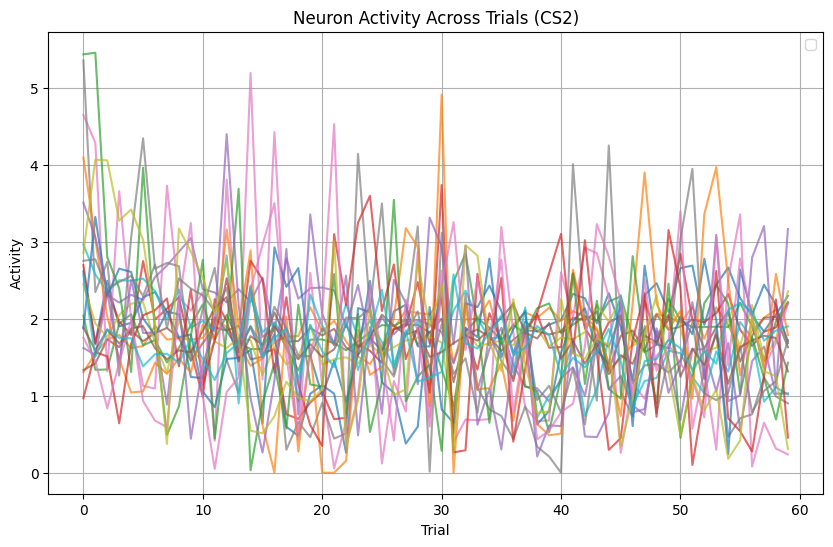

In [37]:
# Select the first 5 neurons for scatter plotting
selected_neurons = 20

plt.figure(figsize=(10, 6))
for i in range(selected_neurons):
    plt.plot(range(cs1_top_learn_act.shape[0]), cs1_top_learn_act[:, i], alpha=0.7)

plt.title("Neuron Activity Across Trials (CS1)")
plt.xlabel("Trial")
plt.ylabel("Activity")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(selected_neurons):
    plt.plot(range(cs2_top_learn_act.shape[0]), cs2_top_learn_act[:, i], alpha=0.7)

plt.title("Neuron Activity Across Trials (CS2)")
plt.xlabel("Trial")
plt.ylabel("Activity")
plt.legend()
plt.grid()
plt.show()

# Select the first 5 neurons for scatter plotting
selected_neurons = 20

plt.figure(figsize=(10, 6))
for i in range(selected_neurons):
    plt.plot(range(top_cumulative_neurons_cs_1_act.shape[0]), top_cumulative_neurons_cs_1_act[:, i], alpha=0.7)

plt.title("Neuron Activity Across Trials (CS1)")
plt.xlabel("Trial")
plt.ylabel("Activity")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(selected_neurons):
    plt.plot(range(top_cumulative_neurons_cs_2_act.shape[0]), top_cumulative_neurons_cs_2_act[:, i], alpha=0.7)

plt.title("Neuron Activity Across Trials (CS2)")
plt.xlabel("Trial")
plt.ylabel("Activity")
plt.legend()
plt.grid()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


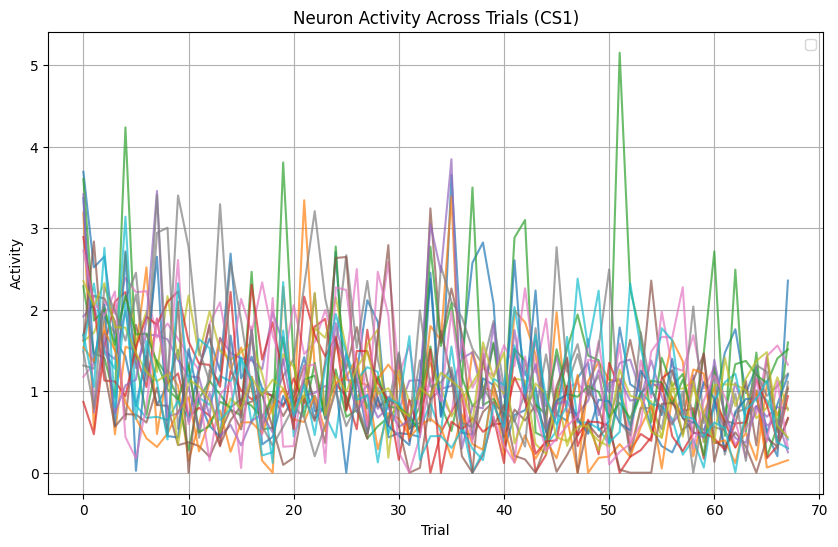

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


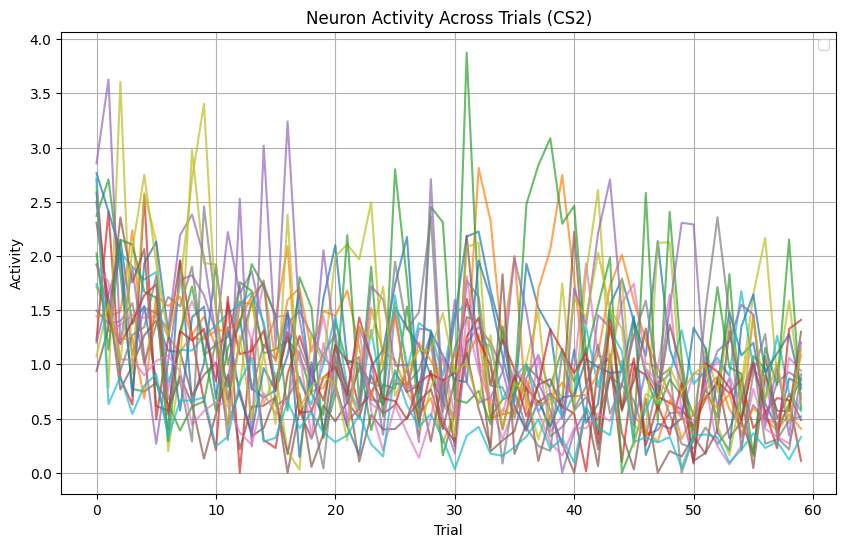

In [16]:
# Select the first 5 neurons for scatter plotting
selected_neurons = 20

plt.figure(figsize=(10, 6))
for i in range(selected_neurons):
    plt.plot(range(cs1_bott_learn_act.shape[0]), cs1_bott_learn_act[:, i], alpha=0.7)

plt.title("Neuron Activity Across Trials (CS1)")
plt.xlabel("Trial")
plt.ylabel("Activity")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(selected_neurons):
    plt.plot(range(cs2_bott_learn_act.shape[0]), cs2_bott_learn_act[:, i], alpha=0.7)

plt.title("Neuron Activity Across Trials (CS2)")
plt.xlabel("Trial")
plt.ylabel("Activity")
plt.legend()
plt.grid()
plt.show()


     Reactivation Index  Trial Index  Similarity to Previous Trial  \
0                     0            1                      0.782337   
1                     1            1                      0.792407   
2                     2            1                      0.858154   
3                     3            2                      0.794728   
4                     4            2                      0.866253   
..                  ...          ...                           ...   
134                 134           65                      0.834599   
135                 135           66                      0.830285   
136                 136           66                      0.682992   
137                 137           66                      0.807118   
138                 138           66                      0.837474   

     Similarity to Current Trial  Similarity to Next Trial  
0                       0.768325                  0.796264  
1                       0.769809     

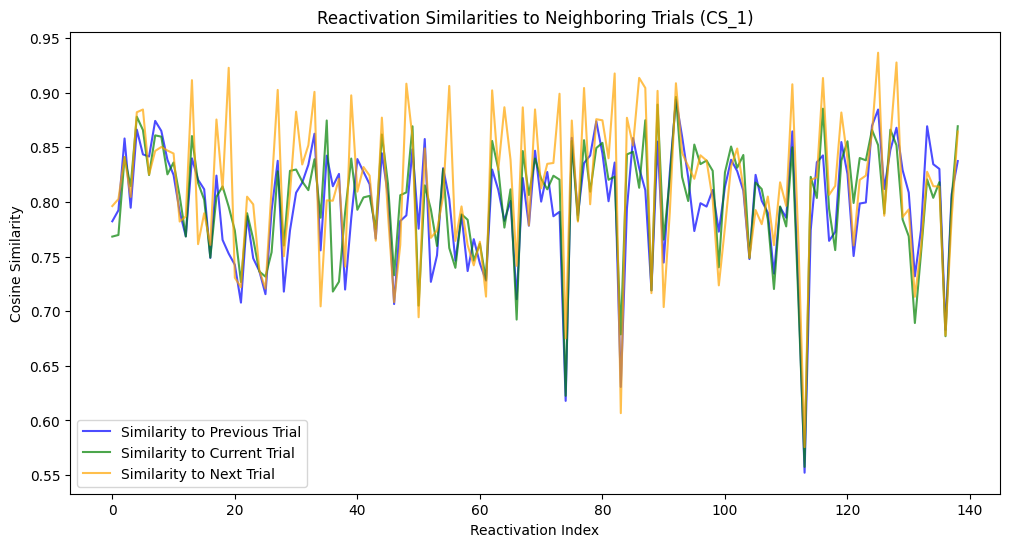

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

# Initialize lists to store similarity results
reactivation_to_trial_similarities = []

#take only top incidices so matching shape
react_top = mean_activity_r_1[:, top_neurons_cs_1]

# Iterate through each reactivation
for r_idx, reactivation in enumerate(react_top):  # Reactivations for CS_1
    trial_idx = trial_r_1[r_idx]  # Get the trial index associated with the reactivation
    
    # Find the neighboring trials (e.g., the current, previous, and next trial means)
    previous_trial_mean = cs1_top_learn_act[trial_idx - 1] if trial_idx > 0 else None
    current_trial_mean = cs1_top_learn_act[trial_idx]
    next_trial_mean = cs1_top_learn_act[trial_idx + 1] if trial_idx < len(cs1_top_learn_act) - 1 else None

    # Calculate cosine similarity for each case
    similarities = {
        "Reactivation Index": r_idx,
        "Trial Index": trial_idx,
        "Similarity to Previous Trial": cosine_similarity(
            reactivation.reshape(1, -1), previous_trial_mean.reshape(1, -1)
        )[0, 0] if previous_trial_mean is not None else np.nan,
        "Similarity to Current Trial": cosine_similarity(
            reactivation.reshape(1, -1), current_trial_mean.reshape(1, -1)
        )[0, 0],
        "Similarity to Next Trial": cosine_similarity(
            reactivation.reshape(1, -1), next_trial_mean.reshape(1, -1)
        )[0, 0] if next_trial_mean is not None else np.nan,
    }
    
    # Append the similarity results for this reactivation
    reactivation_to_trial_similarities.append(similarities)

similarities_df = pd.DataFrame(reactivation_to_trial_similarities)

# Display the similarity results
print(similarities_df)

plt.figure(figsize=(12, 6))

# Plot similarities to each trial type
plt.plot(
    similarities_df["Reactivation Index"], similarities_df["Similarity to Previous Trial"],
    label="Similarity to Previous Trial", color="blue", alpha=0.7
)
plt.plot(
    similarities_df["Reactivation Index"], similarities_df["Similarity to Current Trial"],
    label="Similarity to Current Trial", color="green", alpha=0.7
)
plt.plot(
    similarities_df["Reactivation Index"], similarities_df["Similarity to Next Trial"],
    label="Similarity to Next Trial", color="orange", alpha=0.7
)

# Add labels and legend
plt.xlabel("Reactivation Index")
plt.ylabel("Cosine Similarity")
plt.title("Reactivation Similarities to Neighboring Trials (CS_1)")
plt.legend()
plt.show()


     Reactivation Index  Trial Index  Similarity to Previous Trial  \
0                     0            0                           NaN   
1                     1            1                      0.778479   
2                     2            1                      0.821123   
3                     3            1                      0.846854   
4                     4            2                      0.854529   
..                  ...          ...                           ...   
106                 106           57                      0.850590   
107                 107           58                      0.765268   
108                 108           58                      0.722089   
109                 109           58                      0.781715   
110                 110           58                      0.830916   

     Similarity to Current Trial  Similarity to Next Trial  
0                       0.868895                  0.859343  
1                       0.773591     

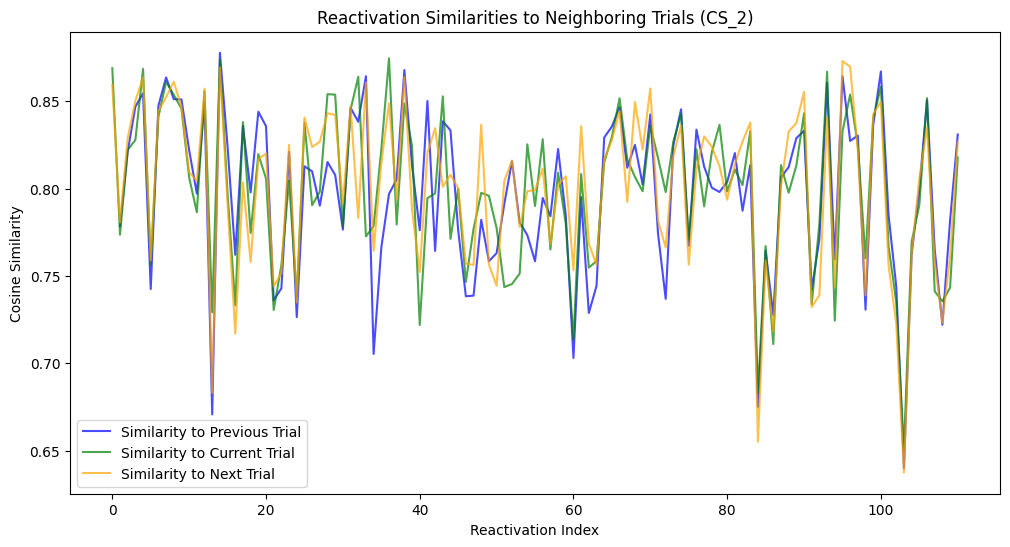

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

# Initialize lists to store similarity results
reactivation_to_trial_similarities = []

#take only top incidices so matching shape
react_top = mean_activity_r_2[:, top_neurons_cs_2]

# Iterate through each reactivation
for r_idx, reactivation in enumerate(react_top):  # Reactivations for CS_1
    trial_idx = trial_r_2[r_idx]  # Get the trial index associated with the reactivation
    
    # Find the neighboring trials (e.g., the current, previous, and next trial means)
    previous_trial_mean = cs1_top_learn_act[trial_idx - 1] if trial_idx > 0 else None
    current_trial_mean = cs1_top_learn_act[trial_idx]
    next_trial_mean = cs1_top_learn_act[trial_idx + 1] if trial_idx < len(cs1_top_learn_act) - 1 else None

    # Calculate cosine similarity for each case
    similarities = {
        "Reactivation Index": r_idx,
        "Trial Index": trial_idx,
        "Similarity to Previous Trial": cosine_similarity(
            reactivation.reshape(1, -1), previous_trial_mean.reshape(1, -1)
        )[0, 0] if previous_trial_mean is not None else np.nan,
        "Similarity to Current Trial": cosine_similarity(
            reactivation.reshape(1, -1), current_trial_mean.reshape(1, -1)
        )[0, 0],
        "Similarity to Next Trial": cosine_similarity(
            reactivation.reshape(1, -1), next_trial_mean.reshape(1, -1)
        )[0, 0] if next_trial_mean is not None else np.nan,
    }
    
    # Append the similarity results for this reactivation
    reactivation_to_trial_similarities.append(similarities)

similarities_df = pd.DataFrame(reactivation_to_trial_similarities)

# Display the similarity results
print(similarities_df)

plt.figure(figsize=(12, 6))

# Plot similarities to each trial type
plt.plot(
    similarities_df["Reactivation Index"], similarities_df["Similarity to Previous Trial"],
    label="Similarity to Previous Trial", color="blue", alpha=0.7
)
plt.plot(
    similarities_df["Reactivation Index"], similarities_df["Similarity to Current Trial"],
    label="Similarity to Current Trial", color="green", alpha=0.7
)
plt.plot(
    similarities_df["Reactivation Index"], similarities_df["Similarity to Next Trial"],
    label="Similarity to Next Trial", color="orange", alpha=0.7
)

# Add labels and legend
plt.xlabel("Reactivation Index")
plt.ylabel("Cosine Similarity")
plt.title("Reactivation Similarities to Neighboring Trials (CS_2)")
plt.legend()
plt.show()


# Predicting sign of change

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Step 1: Expand mean_activity_cs to match reactivation events
def expand_mean_activity(mean_activity, trial_indices):
    """ Map trial-level mean activity to reactivation events. """
    return mean_activity[trial_indices]

expanded_cs_1 = expand_mean_activity(mean_activity_cs_1, trial_r_1)
expanded_cs_2 = expand_mean_activity(mean_activity_cs_2, trial_r_2)

# Step 2: Create Target Labels (Per Neuron)
def construct_labels(expanded_activity, epsilon=1e-5):
    """ Construct binary labels for neuron activity changes. """
    changes = np.diff(expanded_activity, axis=0)  # Trial-to-trial differences
    labels = np.zeros_like(changes)              # Initialize labels as 0
    labels[changes > epsilon] = 1                # +1: Significant increase
    labels[changes < -epsilon] = -1              # -1: Significant decrease
    return labels

labels_r1 = construct_labels(expanded_cs_1)  # Shape: (events-1, neurons)
labels_r2 = construct_labels(expanded_cs_2)

# Step 3: Align Reactivation Data and Labels
reactivations_r1 = mean_activity_r_1[:-1, :]  # Reactivation events aligned to labels
reactivations_r2 = mean_activity_r_2[:-1, :]

X = np.vstack([reactivations_r1, reactivations_r2])  # Combine features
y = np.vstack([labels_r1, labels_r2])               # Combine labels

print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

# Step 4: Train a Multi-Output Classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Logistic Regression as Multi-Output Classifier
log_reg = LogisticRegression(max_iter=1000)
multi_output_clf = MultiOutputClassifier(log_reg)
multi_output_clf.fit(X_train, y_train)


Shape of X: (248, 3124), Shape of y: (248, 3124)


ValueError: multiclass-multioutput is not supported

In [74]:
# Step 5: Evaluate Classifier Performance
y_pred = multi_output_clf.predict(X_test)

# Initialize lists to store metrics per neuron
accuracies = []
precisions = []
recalls = []

from sklearn.metrics import accuracy_score, precision_score, recall_score

# Loop over neurons (columns in y_test and y_pred)
for neuron_idx in range(y_test.shape[1]):
    y_true_neuron = y_test[:, neuron_idx]  # True labels for neuron
    y_pred_neuron = y_pred[:, neuron_idx]  # Predicted labels for neuron
    
    # Skip neurons without any valid predictions (optional)
    if len(np.unique(y_true_neuron)) < 2:
        continue
    
    # Calculate metrics
    acc = accuracy_score(y_true_neuron, y_pred_neuron)
    prec = precision_score(y_true_neuron, y_pred_neuron, average='weighted', zero_division=0)
    rec = recall_score(y_true_neuron, y_pred_neuron, average='weighted', zero_division=0)
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)

# Report average metrics across all neurons
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean Precision: {np.mean(precisions):.4f}")
print(f"Mean Recall: {np.mean(recalls):.4f}")


Mean Accuracy: 0.7149
Mean Precision: 0.7012
Mean Recall: 0.7149


In [76]:
# Combine top neurons from CS_1 and CS_2
top_neurons_indices = np.concatenate([top_neurons_cs_1, top_neurons_cs_2])

# Ensure unique indices in case of overlap
top_neurons_indices = np.unique(top_neurons_indices)

# Subset true labels and predictions for top neurons
y_test_top = y_test[:, top_neurons_indices]
y_pred_top = y_pred[:, top_neurons_indices]

# Initialize lists for per-neuron accuracy
accuracies_top = []
precisions_top = []
recalls_top = []

from sklearn.metrics import accuracy_score, precision_score, recall_score

# Calculate performance for each top neuron
for neuron_idx in range(y_test_top.shape[1]):
    y_true_neuron = y_test_top[:, neuron_idx]
    y_pred_neuron = y_pred_top[:, neuron_idx]

    acc = accuracy_score(y_true_neuron, y_pred_neuron)
    prec = precision_score(y_true_neuron, y_pred_neuron, average='weighted', zero_division=0)
    rec = recall_score(y_true_neuron, y_pred_neuron, average='weighted', zero_division=0)

    accuracies_top.append(acc)
    precisions_top.append(prec)
    recalls_top.append(rec)

# Report average metrics for top neurons
print("\nPerformance on Top 10% Neurons:")
print(f"Mean Accuracy: {np.mean(accuracies_top):.4f}")
print(f"Mean Precision: {np.mean(precisions_top):.4f}")
print(f"Mean Recall: {np.mean(recalls_top):.4f}")



Performance on Top 10% Neurons:
Mean Accuracy: 0.7147
Mean Precision: 0.7003
Mean Recall: 0.7147


In [89]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Combine reactivation data and labels
X = np.vstack([mean_activity_r_1[:-1, :], mean_activity_r_2[:-1, :]])  # Features
y = np.vstack([labels_r1, labels_r2])  # Labels: Sign of activity change

# Extract top 10% neuron indices
top_neurons_indices = np.concatenate([top_neurons_cs_1, top_neurons_cs_2])
top_neurons_indices = np.unique(top_neurons_indices)  # Ensure uniqueness

# Subset features and labels for the top 10% neurons
y_top = y[:, top_neurons_indices]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_top, test_size=0.3, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)  # Input layer to hidden layer
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)          # Hidden layer
        self.fc3 = nn.Linear(256, output_size)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))  # Outputs between -1 and 1
        return x

# Initialize model
input_size = X_train.shape[1]  # Number of neurons in input
print(input_size)
output_size = y_train.shape[1]  # Top 10% neurons
print(output_size)
model = NeuralNetwork(input_size, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Predictions
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = torch.sign(y_pred_tensor).numpy()  # Convert predictions to +1/-1

# Calculate accuracy for each neuron
accuracies = []
for i in range(y_test.shape[1]):
    acc = accuracy_score(y_test[:, i], y_pred[:, i])
    accuracies.append(acc)

print(f"Mean Accuracy for Top 10% Neurons: {np.mean(accuracies):.4f}")


3124
550


RuntimeError: mat1 and mat2 shapes cannot be multiplied (173x3124 and 1024x512)